# NEVADA Airbnb Analysis

### The Clark County, Nevada, USA Airbnb Open Dataset is chosen from http://insideairbnb.com/get-the-data/  
### The analysis is for the UDACITY Project: Write a Data Science Blog Post

The 6 steps of CRISP-DM  
(**Cr**oss-**I**ndustry **S**tandard **P**rocess for **D**ata **M**ining):

1.0 Business Understanding  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   2.0 Data Understading  
3.0 Data Preperation        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   4.0 Modelling  
5.0 Evaluation              &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   6.0 Deployment  



## 1.0 Business Understanding

### Airbnb Business model

Airbnb business model is an aggregator business model. Airbnb acts as a platform to connect hosts and travelers.  Hosts can place their property for stay, and if a traveler wishes to stay there, the hosts get rent in exchange. The individuals and the hosts who are the key components in this model. Airbnb maintains an data driven online platform that connects each component in the business model.  

Nevada Clark County recently shifted legal restrictions for Airbnb. Therefore, we plan to investigate following question based on the data published for last year.

The below investigation tries to investigate the following 3 questions.    

a) What is the area that shows the lowest median price?  

b) What area provides a higher number of rental properties?  

c) How do prices change for each area of Clark County throughout the year? 

### load required modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
sns.set_context("paper", rc={"font.size":30,"axes.titlesize":8,"axes.labelsize":30})   
pal =  sns.set_palette(sns.color_palette("Paired"))

In [2]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

## 2.0 Data Understading

### Gather data

The repository includes 3 CSV files and following 2 files were used in the analysis below.  

**calendar.csv** : The pricing for each listing id for certain days.  
**listings.csv** : detailed description of each listing id.   

In [3]:
#%%pycodestyle
# loading data set downloaded from http://insideairbnb.com/get-the-data/
listings_df = pd.read_csv('data/listings.csv')
calendar_df = pd.read_csv('data/calendar.csv')


In [4]:
#%%pycodestyle
# shape of the data sets
print(f'\n Number of:    Rows     Columns \n Listings:  \
  {listings_df.shape[0]}      {listings_df.shape[1]} \n Calander: \
  {calendar_df.shape[0]}      {calendar_df.shape[1]} ')



 Number of:    Rows     Columns 
 Listings:    11791      74 
 Calander:   4303715      7 


In [5]:
# Checking features in the dataset
listings_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11791 entries, 0 to 11790
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11791 non-null  int64  
 1   listing_url                                   11791 non-null  object 
 2   scrape_id                                     11791 non-null  int64  
 3   last_scraped                                  11791 non-null  object 
 4   name                                          11791 non-null  object 
 5   description                                   11363 non-null  object 
 6   neighborhood_overview                         6763 non-null   object 
 7   picture_url                                   11791 non-null  object 
 8   host_id                                       11791 non-null  int64  
 9   host_url                                      11791 non-null 

In [6]:
# Checking features in the dataset
calendar_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4303715 entries, 0 to 4303714
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           object
 4   adjusted_price  object
 5   minimum_nights  int64 
 6   maximum_nights  int64 
dtypes: int64(3), object(4)
memory usage: 229.8+ MB


### 3.0 Data Preperation

#### Handle Missing data and Categorical Data

First plotting each dataframe **NOT NULL Values** to get a idea about missing and null values.  
For this Calculating NOT NULL data precentage(%) in each feature column.

## Figure 1: not null precentage value for each feature in the 'Listing' dataframe

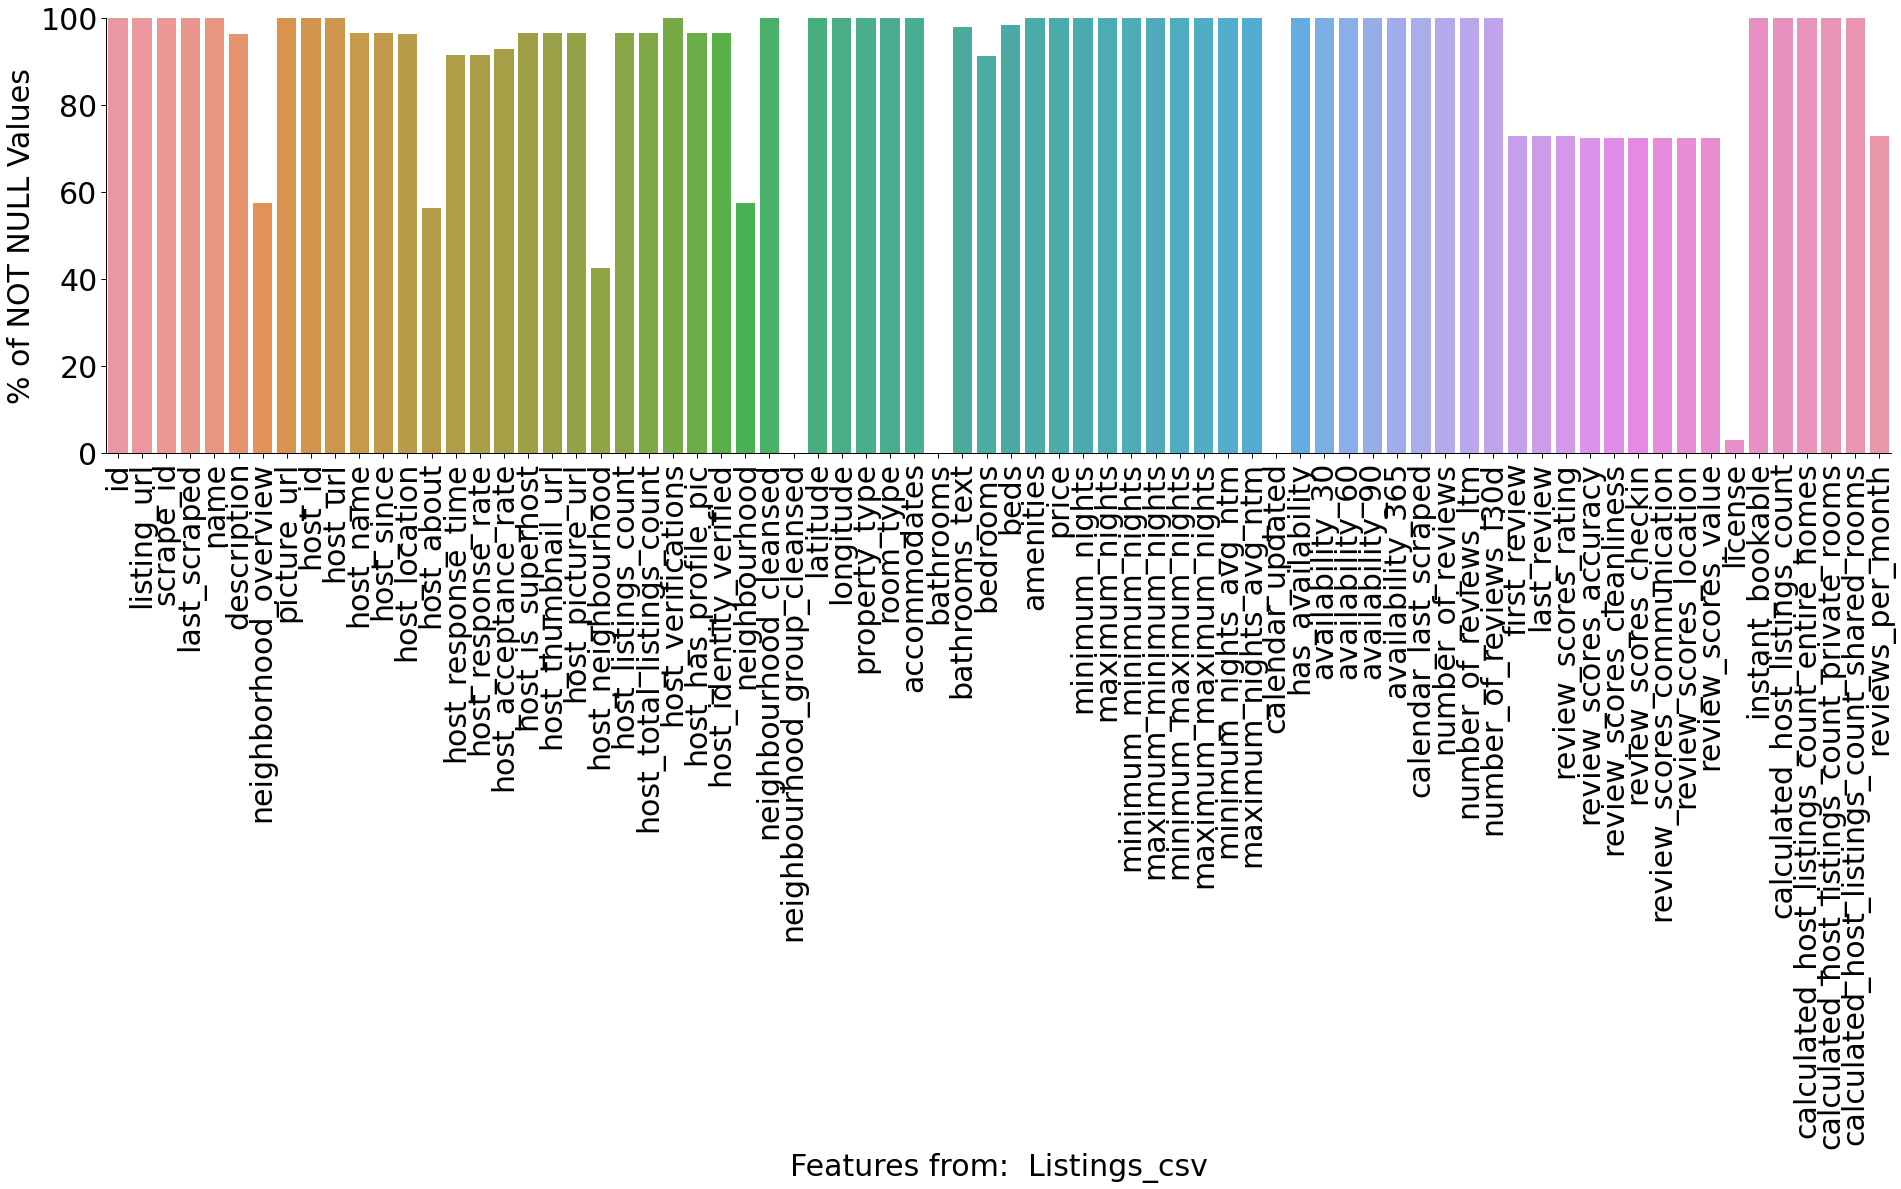

In [7]:
#%%pycodestyle
listing_null = ((listings_df.notnull().mean())*100).to_frame().reset_index()
listing_null.columns = ['index', 'prece']

plt.figure(figsize=(32, 8))
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(0, 100)
ax = sns.barplot(x='index', y='prece', data=listing_null, palette=pal)
sns.despine()
ax.set_xlabel('Features from:  Listings_csv', fontsize=30)
ax.set_ylabel('% of NOT NULL Values', fontsize=30)
plt.show()


## Figure 2: not null precentage value for each feature in the 'Calander' dataframe

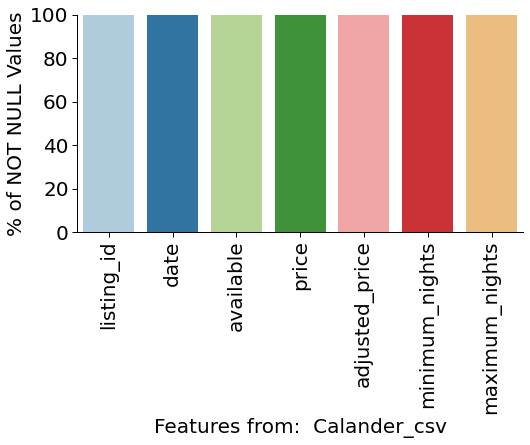

In [8]:
#%%pycodestyle
calander_null = ((calendar_df.notnull().mean())*100).to_frame()
calander_null = calander_null.reset_index()
calander_null.columns = ['index', 'prece']

plt.figure(figsize=(8, 4))
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 100)
ax = sns.barplot(x='index', y='prece', data=calander_null, palette=pal)
sns.despine()
ax.set_xlabel('Features from:  Calander_csv', fontsize=20)
ax.set_ylabel('% of NOT NULL Values', fontsize=20)
plt.show()



Looks like in the **Listings_csv** dataset neighbourhood_group_cleansed, bathrooms, calendar_updated columns all rows are NULL.

Therefore, we can ignore and drop these 3 columns.   

The feature we are interested 'Price' does not include any rows with Null values.  

### Clean data

In [9]:
#%%pycodestyle
# Remove the $ sign from the calendar_df.price. column
calendar_df['price_US_dollars'] = calendar_df.price.replace(
        {'[\$,]':''}, regex=True).astype(float)


In [10]:
#%%pycodestyle
# Extract month with year
calendar_df['month_year'] = pd.to_datetime(calendar_df['date']) \
                                            .dt.to_period('M')


### This is to generate:  
### A NEW dataframe for all the bookings in the 'calander_df' with required fields from the 'listing_df'

Here merge "['neighbourhood_cleansed', 'property_type', 'room_type', 'bedrooms', 'beds', 'bathrooms_text', 'number_of_reviews']" from listings_df with the calander_df 

In [11]:
#%%pycodestyle
# Create joined dataframe with listings_df and calander_df
calander_neighborhood_df = calendar_df.merge(listings_df[
    ['neighbourhood_cleansed', 'property_type', 'room_type', 'bedrooms',
     'beds', 'bathrooms_text', 'number_of_reviews']], how='left',
    left_on=calendar_df['listing_id'], right_on=listings_df['id'])
calander_neighborhood_df.head()


key_0  listing_id        date available    price adjusted_price  \
0  27082775    27082775  2021-12-18         f   $36.00         $36.00   
1  26373705    26373705  2021-12-18         f  $121.00        $121.00   
2  26373705    26373705  2021-12-19         t   $99.00         $99.00   
3  26373705    26373705  2021-12-20         t   $99.00         $99.00   
4  27082775    27082775  2021-12-19         f   $36.00         $36.00   

   minimum_nights  maximum_nights  price_US_dollars month_year  \
0              31            1125              36.0    2021-12   
1               1              28             121.0    2021-12   
2               1              28              99.0    2021-12   
3               1              28              99.0    2021-12   
4              31            1125              36.0    2021-12   

  neighbourhood_cleansed                     property_type     room_type  \
0   Unincorporated Areas  Private room in residential home  Private room   
1   Unincorporated Areas                     Room in hotel  Private room   
2   Unincorporated Areas                     Room in hotel  Private room   
3   Unincorporated Areas                     Room in hotel  Private room   
4   Unincorporated Areas  Private room in residential home  Private room   

   bedrooms  beds  bathrooms_text  number_of_reviews  
0       1.0   1.0  1 private bath                  3  
1       NaN   1.0          1 bath                 63  
2       NaN   1.0          1 bath                 63  
3       NaN   1.0          1 bath                 63  
4       1.0   1.0  1 private bath                  3


### **Calculate the precentage of not null values for each column in the combined dataframe.**

In [12]:
#%%pycodestyle
listing_null = ((calander_neighborhood_df.notnull().mean())*100). \
                to_frame().reset_index()
listing_null.columns = ['index', '% Not Null']
listing_null


index  % Not Null
0                    key_0  100.000000
1               listing_id  100.000000
2                     date  100.000000
3                available  100.000000
4                    price   99.995701
5           adjusted_price   99.995701
6           minimum_nights  100.000000
7           maximum_nights  100.000000
8         price_US_dollars   99.995701
9               month_year  100.000000
10  neighbourhood_cleansed  100.000000
11           property_type  100.000000
12               room_type  100.000000
13                bedrooms   91.239081
14                    beds   98.278348
15          bathrooms_text   98.015436
16       number_of_reviews  100.000000

### Remove NaN values and verify don't have any in each feature column

In [13]:
#%%pycodestyle
calander_neighborhood_df = calander_neighborhood_df.dropna()

listing_null = ((calander_neighborhood_df.notnull().mean())*100). \
                to_frame().reset_index()
listing_null.columns = ['index', '% Not Null']
listing_null


index  % Not Null
0                    key_0       100.0
1               listing_id       100.0
2                     date       100.0
3                available       100.0
4                    price       100.0
5           adjusted_price       100.0
6           minimum_nights       100.0
7           maximum_nights       100.0
8         price_US_dollars       100.0
9               month_year       100.0
10  neighbourhood_cleansed       100.0
11           property_type       100.0
12               room_type       100.0
13                bedrooms       100.0
14                    beds       100.0
15          bathrooms_text       100.0
16       number_of_reviews       100.0

### Now need to pick the records with 'available' feature is set to 'True'

In [14]:
#%%pycodestyle
# get only records with 'available=T'
combined_availa_T_df = \
    calander_neighborhood_df[calander_neighborhood_df.available == 't']
len(combined_availa_T_df)


1848354

In [15]:
#%%pycodestyle
combined_availa_T_df.describe()


key_0    listing_id  minimum_nights  maximum_nights  \
count  1.848354e+06  1.848354e+06    1.848354e+06    1.848354e+06   
mean   4.043884e+07  4.043884e+07    9.215325e+00    4.166563e+05   
std    1.391196e+07  1.391196e+07    1.959674e+01    2.988386e+07   
min    4.449500e+04  4.449500e+04    1.000000e+00    1.000000e+00   
25%    3.169696e+07  3.169696e+07    2.000000e+00    1.820000e+02   
50%    4.579130e+07  4.579130e+07    2.000000e+00    1.125000e+03   
75%    5.185580e+07  5.185580e+07    5.000000e+00    1.125000e+03   
max    5.387990e+07  5.387990e+07    3.650000e+02    2.147484e+09   

       price_US_dollars      bedrooms          beds  number_of_reviews  
count      1.848354e+06  1.848354e+06  1.848354e+06       1.848354e+06  
mean       3.395243e+02  2.132894e+00  3.117386e+00       2.431061e+01  
std        8.263365e+02  1.447292e+00  2.512528e+00       5.205227e+01  
min        1.000000e+01  1.000000e+00  1.000000e+00       0.000000e+00  
25%        9.900000e+01  1.000000e+00  1.000000e+00       0.000000e+00  
50%        1.900000e+02  2.000000e+00  2.000000e+00       4.000000e+00  
75%        3.310000e+02  3.000000e+00  4.000000e+00       2.200000e+01  
max        2.500000e+04  1.600000e+01  2.700000e+01       6.690000e+02

In [16]:
#%%pycodestyle
combined_availa_T_df.head()


key_0  listing_id        date available   price adjusted_price  \
183  27082775    27082775  2022-02-05         t  $36.00         $36.00   
184  27082775    27082775  2022-02-06         t  $36.00         $36.00   
185  27082775    27082775  2022-02-07         t  $36.00         $36.00   
186  27082775    27082775  2022-02-08         t  $36.00         $36.00   
187  27082775    27082775  2022-02-09         t  $36.00         $36.00   

     minimum_nights  maximum_nights  price_US_dollars month_year  \
183              31            1125              36.0    2022-02   
184              31            1125              36.0    2022-02   
185              31            1125              36.0    2022-02   
186              31            1125              36.0    2022-02   
187              31            1125              36.0    2022-02   

    neighbourhood_cleansed                     property_type     room_type  \
183   Unincorporated Areas  Private room in residential home  Private room   
184   Unincorporated Areas  Private room in residential home  Private room   
185   Unincorporated Areas  Private room in residential home  Private room   
186   Unincorporated Areas  Private room in residential home  Private room   
187   Unincorporated Areas  Private room in residential home  Private room   

     bedrooms  beds  bathrooms_text  number_of_reviews  
183       1.0   1.0  1 private bath                  3  
184       1.0   1.0  1 private bath                  3  
185       1.0   1.0  1 private bath                  3  
186       1.0   1.0  1 private bath                  3  
187       1.0   1.0  1 private bath                  3

### 4.0 Data Evaluation

## Question 01

## Figure 3: Plotting violine plots for price distribution for the each area in the Nevada Clark County

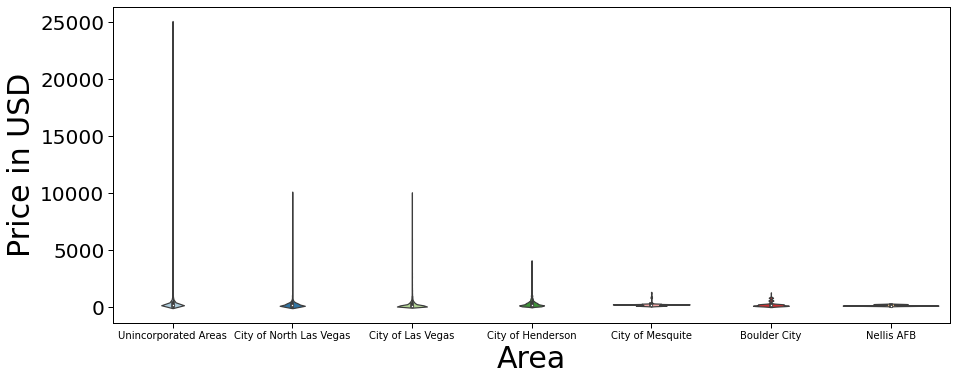

In [17]:
#%%pycodestyle
plt.figure(figsize=(14, 6))
ax = sns.violinplot(y="price_US_dollars",
                    x="neighbourhood_cleansed",
                    data=combined_availa_T_df,
                    annot_kws={"size": 20},)
ax.set_xlabel("Area")
ax.set_ylabel("Price in USD")

plt.xticks(fontsize=10)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()


Although most of the distributions are centered in a narrow range the extreme prices make plots hard to interpret.  
Therefore. calculate the mean value for the price column and choose data less than that for the rest of the analysis.

In [18]:
#%%pycodestyle
# This is a python funtion use to calculate the mean value of a given list
def calc_mean_val(a):
    '''
    Returns mean value of a python list.

            Parameters:
                    a (list): list of values

            Returns:
                    mean (fload): mean value of the list pass with parameter a
    '''
    return np.mean(a)


In [19]:
#%%pycodestyle
print(f' The mean value of the feature :price_US_dollars in the DataFrame =  \
        {calc_mean_val(combined_availa_T_df.price_US_dollars):.2f}')


 The mean value of the feature :price_US_dollars in the DataFrame =          339.52


In [20]:
#%%pycodestyle
mean_val = calc_mean_val(combined_availa_T_df.price_US_dollars)


## Now select only records less than above mean values in the analysis

In [21]:
#%%pycodestyle
less_mean_df = combined_availa_T_df[
    combined_availa_T_df["price_US_dollars"] <= mean_val]


## Figure 4: Rental price destribution for each area in the Clark County

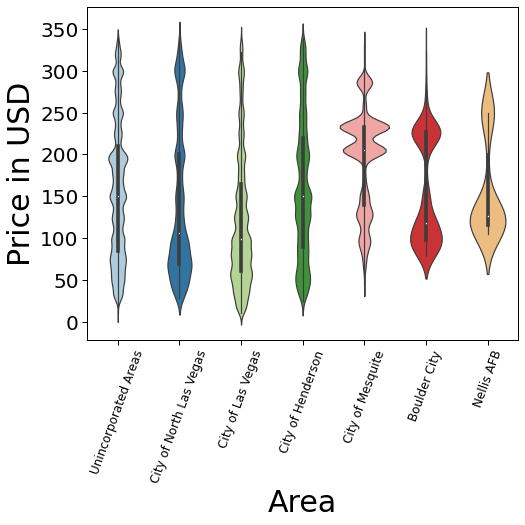

In [22]:
#%%pycodestyle
plt.figure(figsize=(8, 8))
ax = sns.violinplot(y="price_US_dollars",
                    x="neighbourhood_cleansed", data=less_mean_df)
ax.set_xlabel("Area")
ax.set_ylabel("Price in USD")

plt.xticks(fontsize=12, rotation=70)
plt.yticks(fontsize=20)

plt.tight_layout()
# plt.xlabel(fontsize
plt.savefig('Fig_4.png', bbox_inches='tight')
plt.show()


The violin plots median rental price is lowest for the city of Las Vegas.

But we like to have more insight into the data.

## Question 03 (Question 02 is below)

## Figure 5: Plot rental price for each area for each room type

In [23]:
#%%pycodestyle
pal_2 = sns.color_palette("Set2")


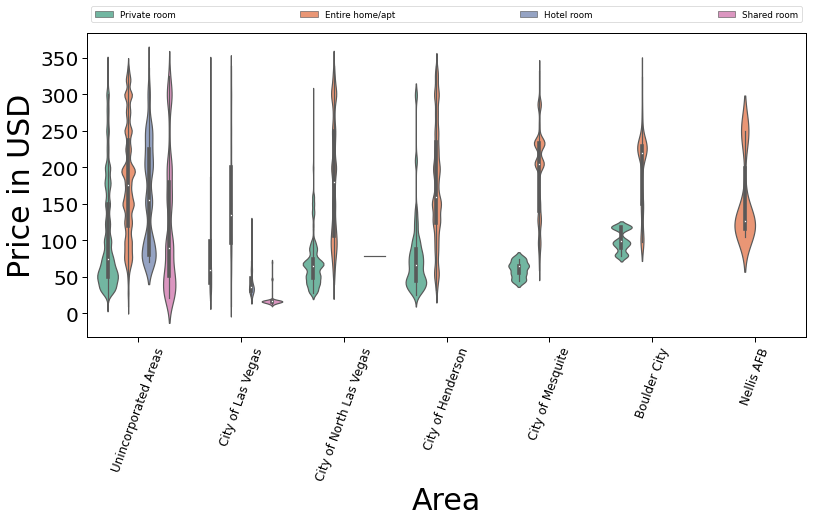

In [24]:
#%%pycodestyle
plt.figure(figsize=(12, 8))
sort_bath = less_mean_df.sort_values('bathrooms_text')
ax = sns.violinplot(y="price_US_dollars",
                    x="neighbourhood_cleansed",
                    hue='room_type',
                    data=sort_bath, palette=pal_2)

ax.set_xlabel("Area")
ax.set_ylabel("Price in USD")

plt.xticks(fontsize=12, rotation=70)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(0, 1.02, 1.0, 0.2),
           loc="lower left", mode="expand", ncol=8)
plt.tight_layout()
plt.savefig('Fig_5.png', bbox_inches='tight')
plt.show()


The above plot shows:

The median price for a ‘private room’ is the lowest if you don’t like the shared option.  
The ‘Hotel rooms’ are only available in ‘Unincorporated area’ and ‘City of Las Vegas’. And in the ‘Nellis AFB’ area only available ‘Entire homes/apartments’.   
However, in these areas the potential new property owners plan to join Airbnb there are opportunities to provide ‘Shared rooms’, and ‘Hotel rooms’ to customers.  

## Question 02 (Question 03 is above)

## Figure 6: Plot rental price for each area for each month in the last year

In [25]:
#%%pycodestyle
pal_3 = sns.color_palette("Paired")


In [26]:
#%%pycodestyle
# sort months to plot them in order
less_mean_df = less_mean_df.sort_values('month_year')


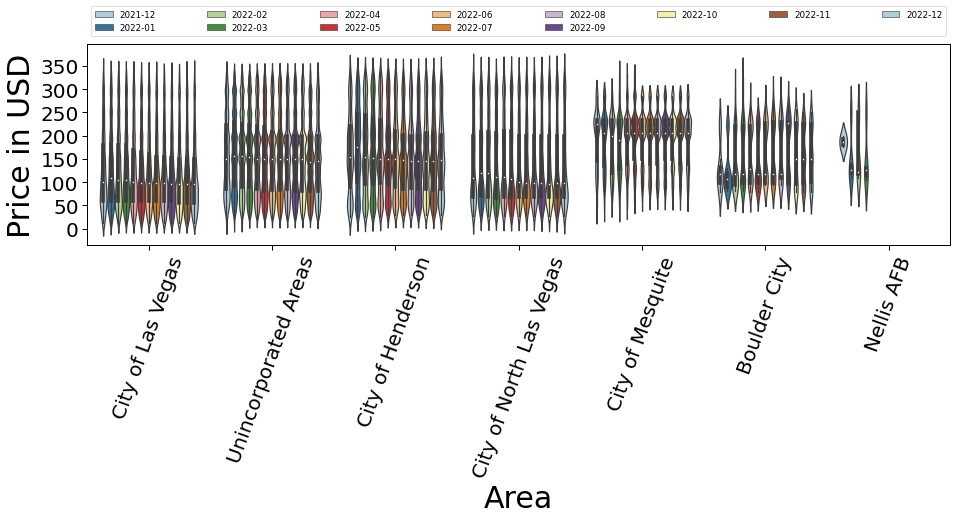

In [27]:
#%%pycodestyle
plt.figure(figsize=(14, 8))
less_mean_df['month_year'] = [str(x) for x in less_mean_df['month_year']]
ax = sns.violinplot(x="neighbourhood_cleansed",
                    y="price_US_dollars",
                    hue="month_year",
                    data=less_mean_df,
                    palette=pal_3)

ax.set_xlabel("Area")
ax.set_ylabel("Price in USD")

plt.xticks(fontsize=20, rotation=70)
plt.yticks(fontsize=20)

plt.legend(bbox_to_anchor=(0, 1.02, 1.0, 0.2),
           loc="lower left", mode="expand", ncol=8)
plt.tight_layout()
plt.savefig('Fig_8.png', bbox_inches='tight')
plt.show()


The above plot shows:  

‘Nellis AFB’ only shows data for the first few months.  
‘Boulder city’ shows the median price highest ($200-$250) for July while all other months’ median prices localize around $100-$150.  
’The ‘City of Mesquite’ then the median price is $200-$250 throughout the year.   
‘City of Las Vegas’ is the median price is lower for all months compared to other areas.  

## Figure 7: Plot rental price for each room type for each month in the last year

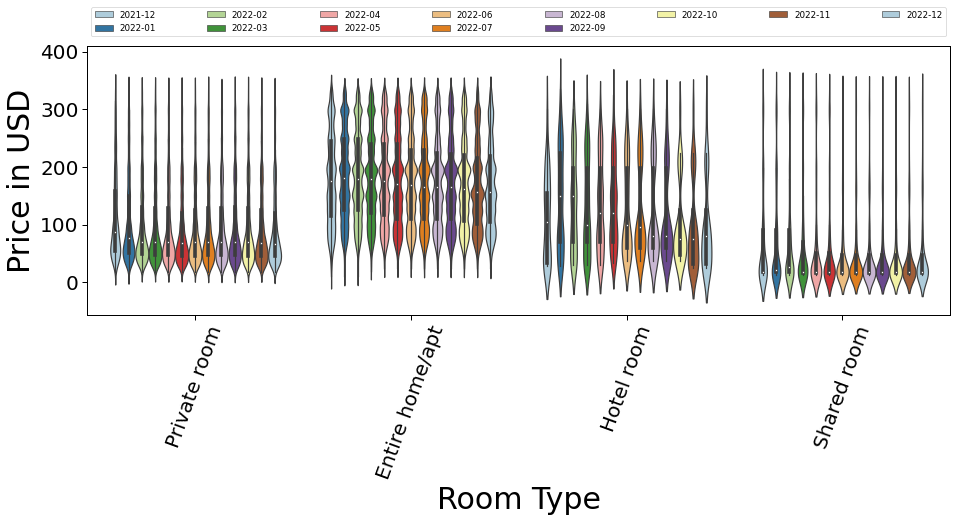

In [28]:
#%%pycodestyle
plt.figure(figsize=(14, 8))
ax = sns.violinplot(x="room_type",
                    y="price_US_dollars",
                    hue="month_year",
                    data=less_mean_df,
                    palette=pal_3)

ax.set_xlabel("Room Type")
ax.set_ylabel("Price in USD")

plt.xticks(fontsize=20, rotation=70)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(0, 1.02, 1.0, 0.2),
           loc="lower left", mode="expand", ncol=8)
plt.tight_layout()
plt.savefig('Fig_9.png', bbox_inches='tight')
plt.show()


## Summary

## Answers: 

1.0 The ‘City of Las Vegas’ area shows the lowest median rental price as shown in Figure 4.  

2.0 But if you look at available ‘Room types’ then ‘Unincorporated area’ provide provides the higher count of rental properties for each room type as shown in Figure 5.  

3.0 Figure 6  shows the median price for a ‘Hotel room’ on Airbnb is slightly higher than August, September, and October months compared to a ‘Private room’. Therefore, pick a hotel in those months if you have an option between them.
Also, Figure 6 shows it is a good idea to avoid ‘City of Mesquite’ if you are trying to find a lower rental price because the median rental is highest in the area throughout the year.